# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
data = pd.read_csv('data_available/selected_data.csv', sep=',')
data.shape 

(7344, 9)

**Predictors**

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,code
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [5]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()
#levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [data.code.nunique(), data.type_house.nunique()]
cat_feat_df['sample'] = [levels_code[:5], levels_type_house]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,code,136,"[nan, W91, Y35, D08, D6W]"
1,type_house,2,"[house, nan, apartment]"


## Split Data

QUITAR LAS VARIABLES AL FINAL DEL NOTEBOOK ANTERIOR

In [6]:
features = [
    'price',
    'floor_area',
#    'views',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = data[features].copy()
data.shape

(7344, 8)

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

We will use the following metrics to evaluate the models:

LaTeX

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

Transformations

https://scikit-learn.org/stable/modules/preprocessing.html

# Models

## Baseline Model

## Multiple Linear Regression

We are going to use the `transformer_estimator` function to encoder categorical variables, transform numerical variables and input the median to numerical variables and fill with `None` categorical ones with missing values.

Then we will use the `scores_statistics` function to plot the metrics after do cross_validation.

In [9]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                          levels_list=[levels_code, levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1, 
                                          num_feat=num_features,
                                          cat_feat=cat_features
                                         )

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.6385428821350709
r2 std: 0.014981942672871269 

MAE mean: -114580.15120890873
MAE std: 3636.8708339469317 

MAPE mean: -0.3663599460194195
MAPE std: 0.010837565199847273 

RMSE mean: -182425.7510863579
RMSE std: 12245.309214032713 



------------

------------

### Overfitting Analysis

Now we are plotting the metrics for the train and test sets. We will use the `metrics_regression` function to do that.

In [10]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6565418947723425
MAE: 111329.76419252346
MAPE: 0.35422605390252876
RMSE: 178186.41943349098

Performance on the test set:
 ----------
R²: 0.6056919434828945
MAE: 106990.12688294591
MAPE: 0.3594920018529949
RMSE: 160136.74861323944



Mean absolute error in the train set is only 5,000€ greater than in the test set so we can consider that there is not overfitting.

### Residuals Diagnostic

The `residuals` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

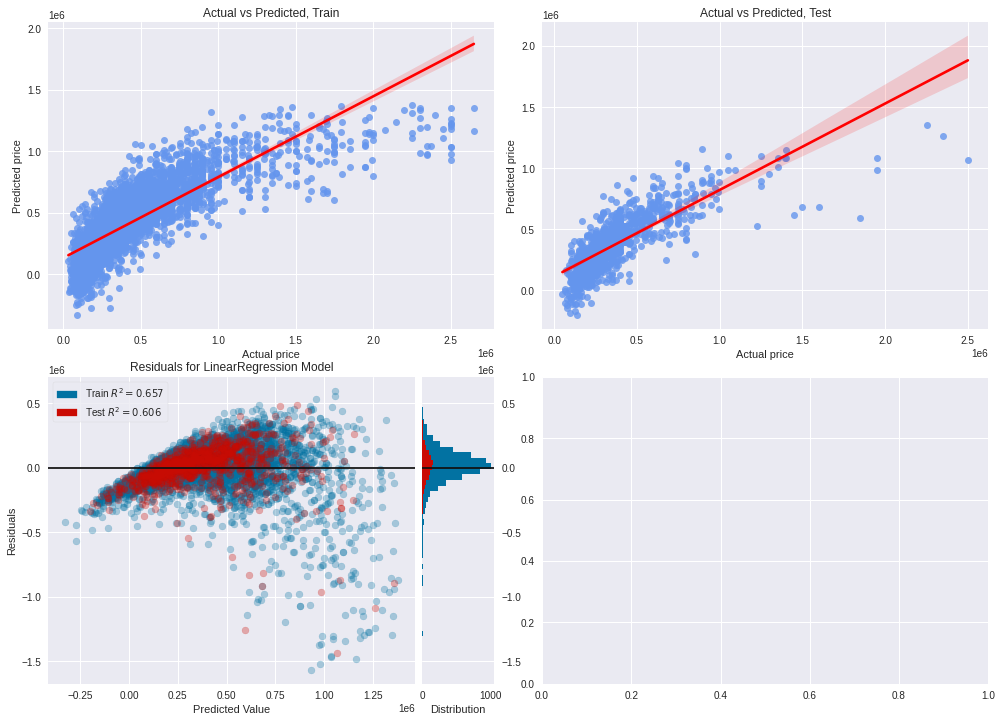

In [11]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

The residuals are calculated extracting `y_train` from `y_pred_train`: y_pred_train - y_train

- The model predices a few negative values, which is not possible in the real world.
- The model doesn't predice well the price of expensive houses. When a house is very expensive the model tends to understimate it.
- We can consider that there is not overfitting.

## Polynomial Regression

First we will instance the GridSearchCV class and fit it to the training set to figure out the best hyperparameters. In this case we will try only different degrees to see what polinomial regression is the best.

In [12]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 3}
0.7475043994942953


In [13]:
# pd.DataFrame(grid_search.cv_results_) # plotearlo

Once we have the best degree we use it to get an estimator and use it as a parameter to the function `scores_statistics`, as we did earlier. 

In [14]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7475043994942953
r2 std: 0.01565574126661351 

MAE mean: -95042.44748391473
MAE std: 2983.3022160909354 

MAPE mean: -0.2761964976680359
MAPE std: 0.008867172610069635 

RMSE mean: -152275.50798551686
RMSE std: 8149.481989066285 



### Overfitting Analysis

In [15]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.7716279698936316
MAE: 90819.78253894637
MAPE: 0.26287242234593095
RMSE: 145297.84478598036

Performance on the test set:
 ----------
R²: 0.7406695101479435
MAE: 84580.92759424279
MAPE: 0.2647359471186111
RMSE: 129867.34779392317



As we can see the polynomial regression with degree three perform better than a multiple linear regression.

### Residuals Diagnostic

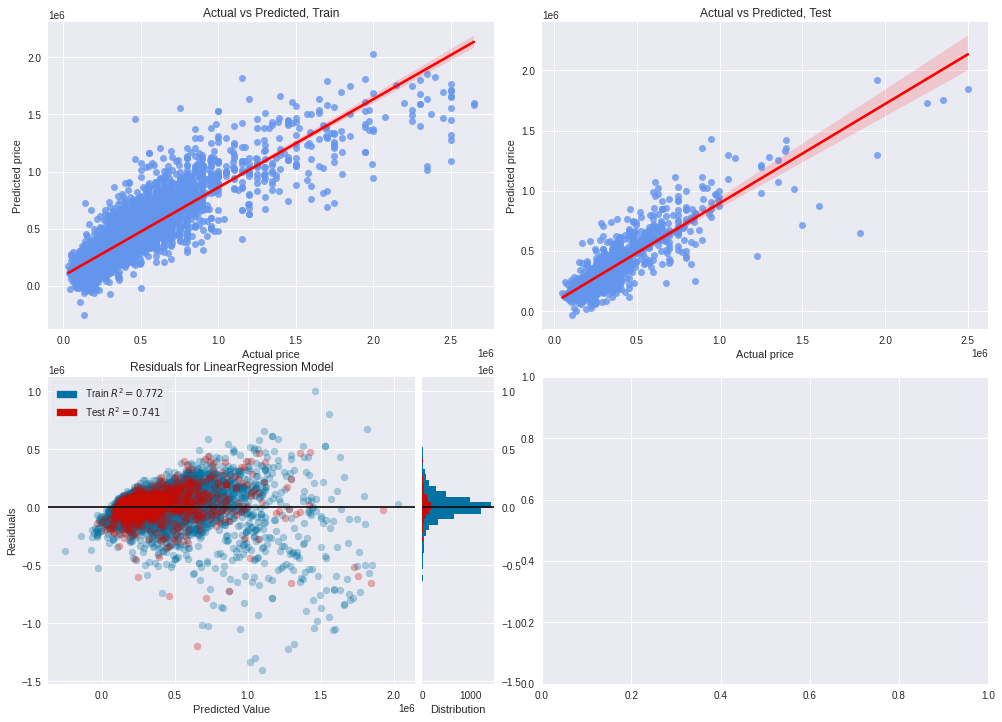

In [16]:
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

- The model still predices a few negative values.
- The model doesn't predice well the price of expensive houses. It also tends to understimate the value of expensive houses but is better than the linear regression.
- We can consider that there is not overfitting.

## K Nearest Neighbors Regressor

In [17]:
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7524463438092918


In [18]:
# We use weights = 'uniform' instead of 'distance' to reduce overfitting
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', # distanc hace que haya mucho overfititng
                                                                          leaf_size= 30), 
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=knnr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False, 
                                          return_est=True
                                         )

r2 mean: 0.7418281398733264
r2 std: 0.018611308789264206 

MAE mean: -89904.822404627
MAE std: 3245.1154521894887 

MAPE mean: -0.24767287366449992
MAPE std: 0.00823181830716877 

RMSE mean: -153997.83834398555
RMSE std: 9876.196137904775 



In [19]:
len(scores['estimator'])#[0] == scores['estimator'][2]

5

Surgen tantos estimators como splits de modo que crearemos otro para que los imputers trabajen con todos los valores.

### Overfitting Analysis

In [20]:
knnr = knnr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8150594093691621
MAE: 75984.16764315467
MAPE: 0.20857428371887576
RMSE: 130753.65457606062

Performance on the test set:
 ----------
R²: 0.7457128445280258
MAE: 78811.78428830697
MAPE: 0.2275412838229052
RMSE: 128598.34898832208



The difference between performance in the training set is similar to the test set so it is okay in my opinion.

### Residuals Diagnostic

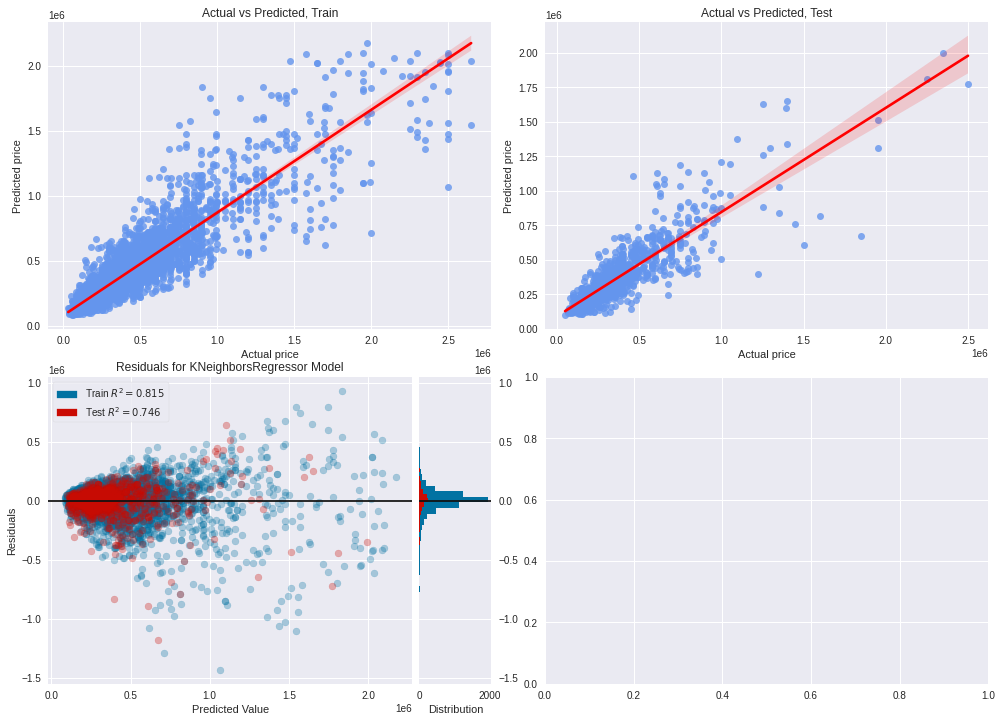

In [21]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

- This time we don't have negative values!
- The model is not very good predicing prices of houses with actual prices above a million, but there is no so clear tendency to understimate them as in the previous models, but there it is.
- There is a litle bit more overfitting than in the previous one but is not too much. It is okay in my opinion.

## Decision Tree Regressor

In [88]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 13, 'regressor__min_samples_leaf': 10}
0.7421685701846625


In [89]:
#pd.DataFrame(grid_search.cv_results_)

In [120]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(max_depth=10,
                                                                           min_samples_leaf=30,  #16
                                                                       #   min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7222396055324022
r2 std: 0.017794039635035692 

MAE mean: -96192.44876010538
MAE std: 3413.046066623118 

MAPE mean: -0.2724820746882649
MAPE std: 0.00778145384923567 

RMSE mean: -159782.83465353952
RMSE std: 10107.43826801812 



### Overfitting Analysis

In [121]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7798223732685527
MAE: 83873.77600504107
MAPE: 0.237526242554888
RMSE: 142667.25631335969

Performance on the test set:
 ----------
R²: 0.7171117938156646
MAE: 83673.75995924712
MAPE: 0.24618600925157766
RMSE: 135637.7578130579



The different in MAE is insignificant so there is no overfitting. I have changed the parameter values to regularize a little the model as the different in the metrics was bigger earlier. That is why the parameters are different that the GridSearchCV ones.

### Residuals Diagnostic

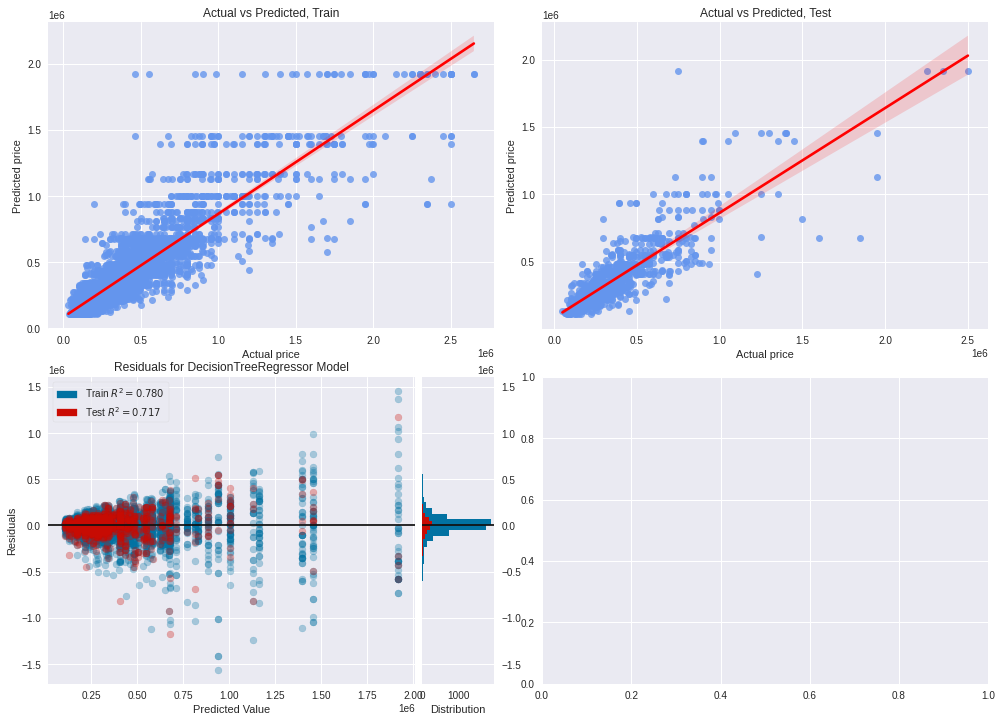

In [122]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

- The model appears to be pretty accurate in values less than 1 million € but the errors increase a lot as the actual price increases as well.
- There is a tendency to understimate values and it is clearer in houses with high values. 
- There is no overfitting.

## Voting Regressor with Basic Algorithms

I think it is interesting to investigate how the basic algorithms we used above can perform together. So let's do a voting regresor with them to figure out that.

In [123]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

Calculate the weights: we will use the performance in the test set to calculate the weights.

In [124]:
models_r2 = {'poly': 74.06, 'knn': 74.57, 'dt': 71.71}

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.3361169102296451,
 'knn': 0.33843151493146956,
 'dt': 0.32545157483888537}

In [125]:
polyr = poly_pipe_estimator
knnr = knnr_pipe_estimator
dtr = dtr_pipe_estimator


voting_regressor_BA = VotingRegressor(
    estimators = [('poly', polyr),
                  ('knn', knnr),
                  ('dt', dtr)], 
    weights = models_weigth_list)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
               'Voting Regressor': voting_regressor_BA}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
MAPE mean: -0.27526340820935996
RMSE mean: -151783.5130225027
----------
K Nearest Neighbors Regressor
r2 mean: 0.742996312910319
MAE mean: -89612.19564263737
MAPE mean: -0.2463997356120617
RMSE mean: -153153.74470609083
----------
Decission Tree Regressor
r2 mean: 0.7159449641172447
MAE mean: -95644.21879010797
MAPE mean: -0.26881459483413495
RMSE mean: -160825.50056806934
----------
Voting Regressor
r2 mean: 0.7853555364170756
MAE mean: -82277.93725936257
MAPE mean: -0.23017622237633534
RMSE mean: -140082.1610656593
----------


Cool! We have been able to improve the performance with the voting regressor. Next we will do the overfitting analysisand the residuals diagnostic before start making more complex models. 

### Overfitting Analysis

In [126]:
voting_reg.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8505410357846581
MAE: 69557.41938306301
MAPE: 0.195172468502991
RMSE: 117543.52219740825

Performance on the test set:
 ----------
R²: 0.7969734064274765
MAE: 71477.100023634
MAPE: 0.21453675252820248
RMSE: 114907.83578739919



The different in MAE is less than 2,000€ so we will consider there is no overfitting.

### Residuals Diagnostic

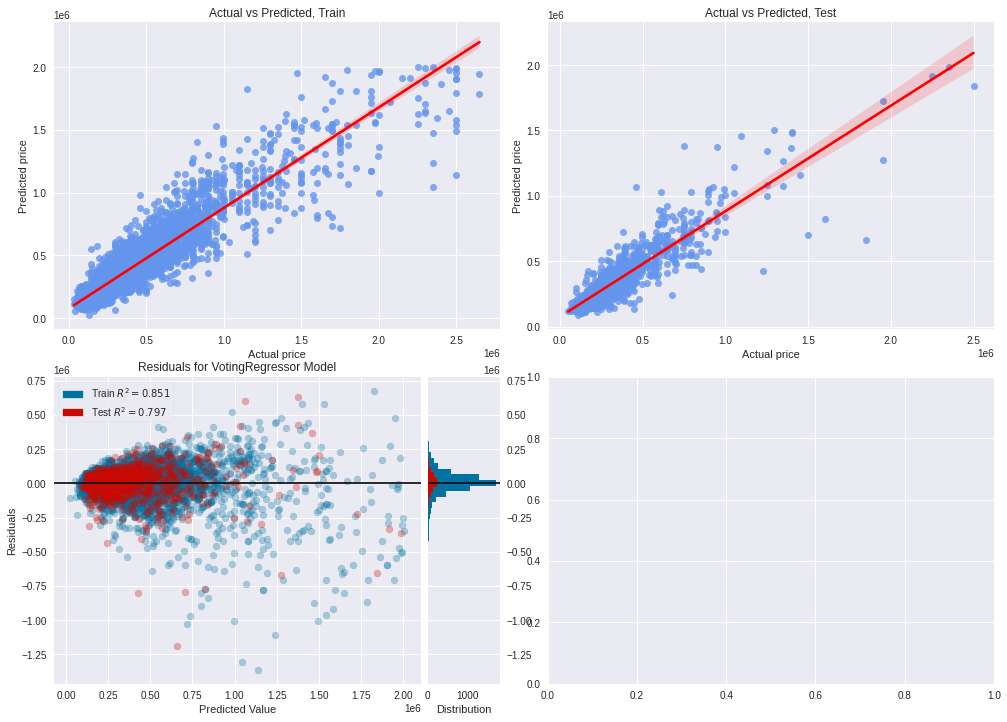

In [127]:
residuals(voting_reg, X_train, X_test, y_train, y_test)

- The voting regressor is clearly better than the models separately.  
- Once again we can realise taht houses which actual price is higher than 1 million € are generally worst predicted than the other ones.
- There is a clear tendency to understimate prices as the actual prices increase. This is normal as the models that make up the voting regressor suffer the same condition.

## Random Forest Regressor

### Out-of-bag 

In [32]:
df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

preprocessor = ColumnTransformer([
     #   ('num', PowerTransformer(method='yeo-johnson'), num_features),
        ('num', IdentityTransformer(), num_features),
        ('cat', OneHotEncoder(), cat_features),
        ]) #, remainder='passthrough' categories=[levels_code, levels_type_house]

X2 = preprocessor.fit_transform(X2)
print(X2.shape)




X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

(7344, 145)


In [150]:
rfr = RandomForestRegressor(n_estimators=180,
                            max_depth=10,
                            min_samples_leaf=9,
                            bootstrap=True,
                            oob_score    = True,
                            random_state=7,   
                            n_jobs=-1)
    
rfr.fit(X_train2, y_train2)
print('Train score:', rfr.score(X_train2, y_train2))
print('Out-of-bag score', rfr.oob_score_)

Train score: 0.8583806481411977
Out-of-bag score 0.8017037879332035


### CV

At first I build and evaluated the model doing cross validation, which is less efficient.

In [168]:
rfr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               max_depth=10,
                                               min_samples_leaf=9,  
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.794641465624331
r2 std: 0.018112079632028447 

MAE mean: -80443.75568041294
MAE std: 2978.3975389245284 

MAPE mean: -0.23049798133955018
MAPE std: 0.007660383919815084 

RMSE mean: -137330.50697156688
RMSE std: 9705.753740324057 



### Overfitting Analysis

In [169]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8583618703728727
MAE: 67352.18709066958
MAPE: 0.19757271429320578
RMSE: 114426.81445309805

Performance on the test set:
 ----------
R²: 0.776357991570882
MAE: 71775.41003895273
MAPE: 0.21586184754516216
RMSE: 120600.71233261416



The different between MAE is less than 5,000€ which is okay.

### Residuals Diagnostic

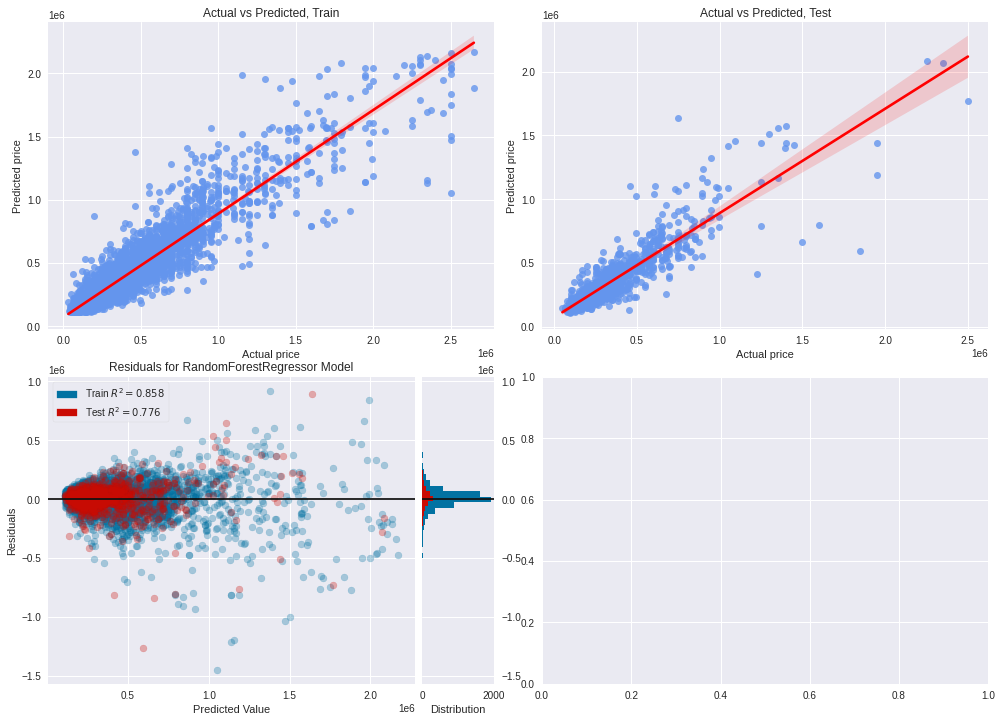

In [170]:
residuals(rfr, X_train, X_test, y_train, y_test)

- The tendency to understimate high values is a little smoother in the random forest.
- The model's performance is better predicting houses prices cheapper than a million euros than highers as well. 
- The voting regressor is still better than the random forest.

## Extreme Gradient Boosting

In [37]:
df = data.copy()
y3 = df['price']
X3 = df.drop(columns='price')

preprocessor = ColumnTransformer([
        ('num', PowerTransformer(method='yeo-johnson'), num_features),
        ('cat', OneHotEncoder(), cat_features),
        ]) #, remainder='passthrough' categories=[levels_code, levels_type_house]

X3 = preprocessor.fit_transform(X3)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=.15,
                                                        random_state=7)

xgb3 = XGBRegressor(n_estimators= 300, 
                                           max_depth=3,
                                           learning_rate=.1,
                                           subsample=.25
                   )

eval_set = [(X_test3, y_test3)]
xgb3.fit(X_train3, y_train3, 
            eval_set=[(X_train3, y_train3), (X_test3, y_test3)], 
           # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.50000	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.43750	validation_1-rmse:373322.34375
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355672.06250	validation_1-rmse:313810.03125
[4]	validation_0-rmse:330057.06250	validation_1-rmse:289391.84375
[5]	validation_0-rmse:306698.09375	validation_1-rmse:267665.34375
[6]	validation_0-rmse:286240.09375	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268081.65625	validation_1-rmse:231536.37500
[8]	validation_0-rmse:251999.42188	validation_1-rmse:216863.78125
[9]	validation_0-rmse:238578.59375	validation_1-rmse:205284.67188
[10]	validation_0-rmse:226886.07812	validation_1-rmse:194387.87500
[11]	validation_0-rmse:216014.00000	validation_1-rmse:185007.46875
[12]	validation_0-rmse:207417.70312	validation_1-rmse:177402.84375
[13]	validation_0-rmse:198726.09375	validation_1-rmse:170096.68750
[14]	validation_0-rmse:191707.32812	validation_1-rmse:163957.82812
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

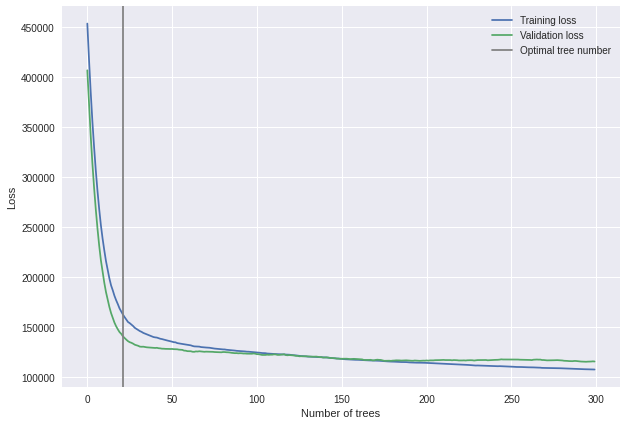

In [38]:
results = xgb3.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

In [39]:
xgb_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                           regressor=XGBRegressor(
                                               n_estimators= 177, #150
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.30),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8012243905382925
r2 std: 0.037220808799236046 

MAE mean: -82300.97687253806
MAE std: 4712.640571680671 

MAPE mean: -0.237468313674644
MAPE std: 0.00964037015449505 

RMSE mean: -134288.66652937303
RMSE std: 12739.450348506041 



### Overfitting Analysis

In [40]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8571721475324723
MAE: 74840.05653987103
MAPE: 0.22504862608920886
RMSE: 114906.3869821748

Performance on the test set:
 ----------
R²: 0.7910316768408792
MAE: 72701.63284085754
MAPE: 0.22187505127996696
RMSE: 116577.14361247883



### Residuals Diagnostic

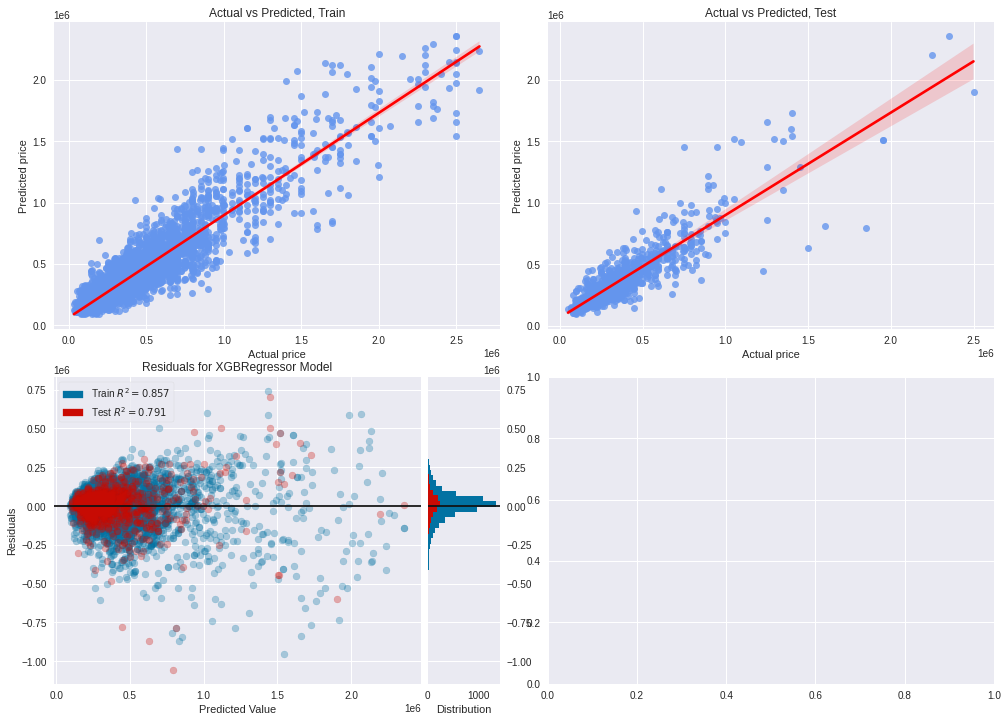

In [41]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

## Voting Regressor with Ensemble Methods

In [42]:
models_r2 = {'poly': 73.41, 'rfr': 80.92, 'xgb': 79.92} 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.3133831376734258,
 'rfr': 0.34544290288153684,
 'xgb': 0.34117395944503737}

In [43]:
polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
----------
Random Forest Regressor
r2 mean: 0.79616513175961
MAE mean: -79389.28984153559
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8071215989415552
MAE mean: -79147.09453722028
----------


In [44]:
voting_regressor1.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor1.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor1.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8532277835005754
MAE: 71065.63866927724
MAPE: 0.20472343518024191
RMSE: 116482.22091825468

Performance on the test set:
 ----------
R²: 0.799567169135116
MAE: 70142.34306774173
MAPE: 0.21390028036326944
RMSE: 114171.47485931507



Y si en lugar de usar el Polynomial Regression usamos el Voting Regressor with Basic Algorithms?

In [45]:
models_r2 = {'voting_reg': 77.81, 'rfr': 80.92, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_reg': 0.3260423213911586,
 'rfr': 0.3390739576786088,
 'xgb': 0.3348837209302325}

In [46]:
voting_reg = voting_reg
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_reg),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_reg, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7975850002834377
MAE mean: -80647.81071457635
----------
Random Forest Regressor
r2 mean: 0.79616513175961
MAE mean: -79389.28984153559
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8132029012674122
MAE mean: -77247.22773949712
----------


In [47]:
voting_regressor2.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor2.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor2.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8677421856551195
MAE: 66708.30634107967
MAPE: 0.19270776899010947
RMSE: 110572.82026892579

Performance on the test set:
 ----------
R²: 0.8047726497179954
MAE: 68312.83469628352
MAPE: 0.20688654490168992
RMSE: 112679.13671902473



y sin ninguno?

In [48]:
models_r2 = {'rfr': 80.92, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'rfr': 0.5031086794329769, 'xgb': 0.4968913205670231}

In [49]:
#polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.79616513175961
MAE mean: -79389.28984153559
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8089083719369958
MAE mean: -78615.12544107425
----------


In [50]:
voting_regressor3.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor3.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor3.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.866949808417535
MAE: 68196.69389386497
MAPE: 0.20035075676971853
RMSE: 110903.55516192323

Performance on the test set:
 ----------
R²: 0.7950287389788672
MAE: 69629.49143901927
MAPE: 0.21100815938777692
RMSE: 115456.8401828879



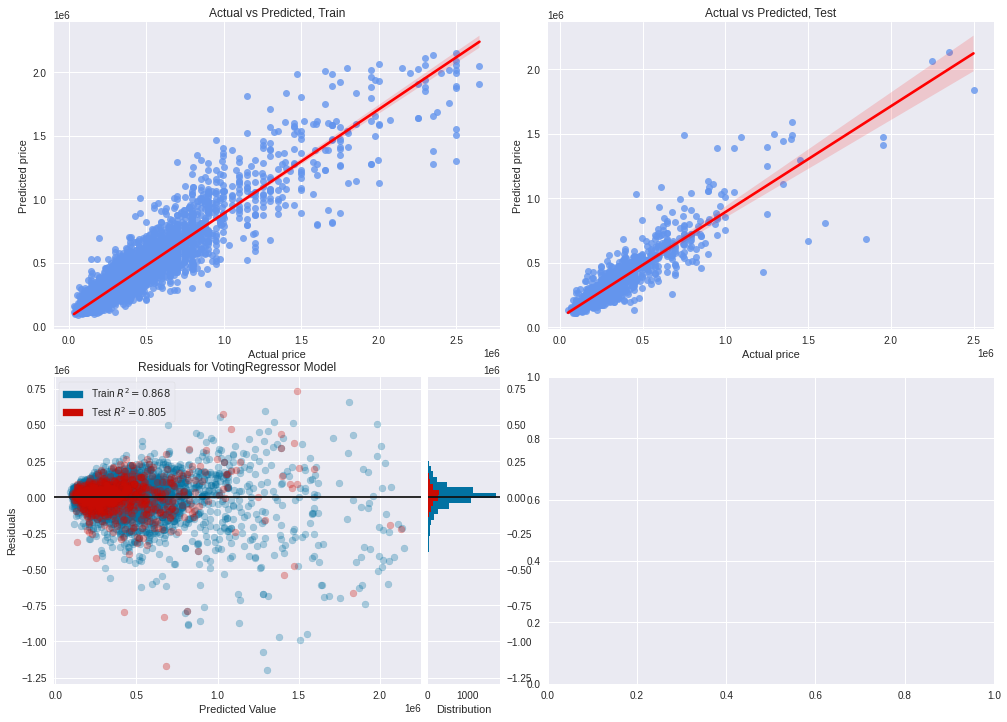

In [51]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

## Stacking

Regression Meta-Model: Linear Reagression

In [52]:
from sklearn.ensemble import StackingRegressor

In [53]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('polyr', poly_pipe_estimator))
    level0.append(('rfr', rfr_pipe_estimator))
    level0.append(('egb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [54]:
models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'Random Forest Regressor': rfr_pipe_estimator, 
               'XGBoost': xgb_pipe_estimator,
               'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
----------
Random Forest Regressor
r2 mean: 0.7961651317596099
MAE mean: -79389.28984153559
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Stacking
r2 mean: 0.8093395702678853
MAE mean: -78769.37941525511
----------


In [55]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8644426586371566
MAE: 69853.20295796756
MAPE: 0.2013482363802997
RMSE: 111943.59178867977

Performance on the test set:
 ----------
R²: 0.79791412347358
MAE: 69758.25994063457
MAPE: 0.2080820027558274
RMSE: 114641.31586155939



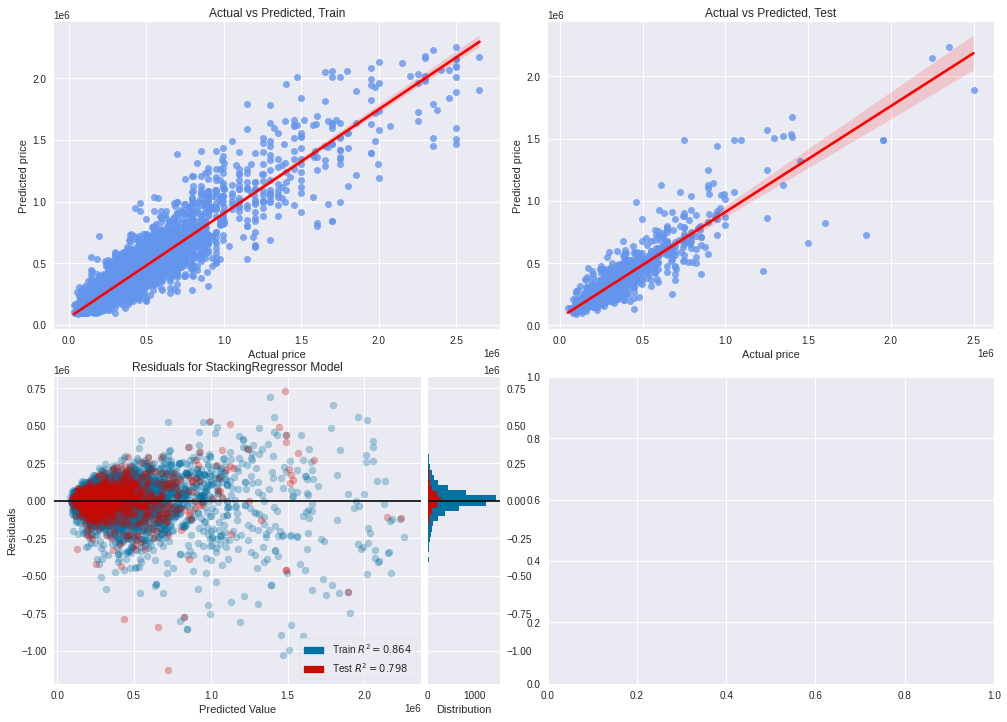

In [56]:
residuals(stacking, X_train, X_test, y_train, y_test)

# Dataset to try the frontend:

In [57]:
srthrsg

NameError: name 'srthrsg' is not defined

In [ ]:
X_test.shape, y_test.shape, y_pred.shape

In [ ]:
X_test.sample()

In [ ]:
y_test.sample()

In [ ]:
y_pred = pd.Series(y_pred.copy())
y_pred.sample()

In [ ]:
X_test.isna().sum()

In [ ]:
y_test.isna().sum()

In [ ]:
y_pred.isna().sum()

In [ ]:
y_pred.head(5)

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
data.columns

In [ ]:
X = data[['floor_area', 'latitude', 'longitude', 
          'bedroom', 'bathroom', 'type_house', 'code']].copy()
y = data['price']

#data_to_frontend = X.copy()
#data_to_frontend['price'] = y.copy()

data_to_frontend = data.copy()
xgb = xgb_pipe_estimator.fit(X_train, y_train)

y_pred = xgb.predict(X)

data_to_frontend['inferred_price'] = list(y_pred) # me daba muchos nan si lo unia siendo una series
data_to_frontend['difference'] = data_to_frontend.inferred_price - data_to_frontend.price
data_to_frontend.sample()

In [ ]:
data_to_frontend.isna().sum()

In [ ]:
data_to_frontend.difference.head()

In [ ]:
print(data_to_frontend.difference.min())
print(data_to_frontend.difference.max())    
print(data_to_frontend.difference.mean())    

In [ ]:
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].min())

In [ ]:
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min())

In [ ]:
nan_array = np.empty(data_to_frontend.shape[0])
nan_array[:] = np.NaN
nan_ser = pd.Series(nan_array)
nan_ser.shape

In [ ]:
data_to_frontend['dif_per'] = nan_ser
data_to_frontend.sample()

In [ ]:
max_pos = data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max()
max_neg = data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min()

def difference_percentage(dif):
    
    if dif > 0:
        result = dif / max_pos
    elif dif < 0:
        result = -(dif / max_neg)
        
    return result

In [ ]:
for i, row in data_to_frontend.iterrows():
    #print(row.difference)
    
    dif_per = difference_percentage(row.difference)
        
    data_to_frontend.loc[i, 'dif_per'] = dif_per
    

In [ ]:
data_to_frontend.sample()

In [ ]:
data_to_frontend.isna().sum()

In [ ]:
data_to_frontend.to_csv('FrontEnd/data_predicted.csv', sep=',', index=False)